## Workshop on Practical Data Analysis in Earth and Planetary Science. Seminar 2

every Monday at 4pm (CEST), at the Center for Planetary Habitability (PHAB), Wegener's room (1st floor, ZEB-building) and everywhere in Zoom https://uio.zoom.us/j/61896722660, Meeting ID: 618 9672 2660

In this workshop we look at time series and data analysis in frequency domain. Useful reference material is in Chapter 5 of M. Trauth's book. We will contnue working with the examples from the introductory seminar, such as working with images and analyses of tabular data (linear regression). We will use UiO ChatGPT service https://gpt.uio.no/chat to solve some problems and convert matlab codes to python and back.   

### FFT

Fast Fourier Transform (FFT) plays the critical role in analysing and interpreting geophysical data such as seismic waves, gravity and magnetic data, and other signals to extract meaningful information about the subsurface structure and properties. The ability to decompose complex signals into their frequency components through the Fourier Transform provides valuable insights into geophysical phenomena. 
The algorithm was originally invernted around 1805 by Carl Friedrich Gauss, who used it to interpolate the trajectories of the asteroids Pallas and Juno, but his work was not widely recognized https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm 

Around 1965 the FFT algorithm was published (reinvented) by Cooley and Tukey, who originally applied this technique to processing of seismological nuclear test monitoring data.


There is probably no more fundamental concept in geophysics as fast Fourier Transform (FFT)

Y = fft(X) and X = ifft(Y) implement the Fourier transform and inverse Fourier transform, respectively. For X and Y of length n, these transforms are defined as follows:

Forward discrete FT \
$Y(k) = \sum_{n=1}^N X(n)\exp(-i2\pi(k-1)(n-1)/N), 1 \le k \le N. $

Inverse transform FT \
$X(n) = \sum_{k=1}^N Y(k)\exp(i2\pi(k-1)(n-1)/N), 1 \le n \le N. $


In the following MATLAB example, we will read a Moon image and do some image sharpening using inverse Gaussian filterinig in frequancy domain

In [ ]:
% read input image

websave('planet_img.jpg','https://www.solarsystemscope.com/textures/download/2k_moon.jpg')
im = imread('planet_img.jpg');
% convert the image to double precision and grayscale
im = im2double(rgb2gray(im));
im = im(500:700,500:700);
I = fft2(im);%forward 2D FFT transform

% display the image 
% "fftshift" shift zero-frequency component to center of spectrum
%figure,
subplot(331),imshow(im),  title('Original image')
subplot(332),imshow(abs(fftshift(I))), caxis([0 100]), title('Original image (FFT)')

%% Gaussian filter 
% FFT of Gaussian is another Gaussian
h = fspecial('gaussian', [35 35], 5); h=h/max(abs(h(:)));
H = fft2(h, size(im,1), size(im,2)); H = H/max(abs(H(:)));
%figure, 
subplot(333),imshow(h), title('Gaussian filter')
subplot(334),imshow(abs(fftshift(H))),title('Frequency domain')
%%

I_bl = I.*H; %filtering (multiplication of FFT cofficients)
im_bl = real(ifft2(I_bl));%blurred image

%figure,
subplot(335),imshow(im_bl),  title('Blurred image')
subplot(336),imshow(abs(fftshift(I_bl))), caxis([0 100]), title('Blurred image (FFT)')

%% Deblurring using inverse Gassian filter (deconvolution) 
% choose a filter 
%flt = fspecial('disk', 25);
%flt = -fspecial('laplacian',.5);
flt = fspecial('gaussian', [15 15],15);
FLT = fft2(flt, size(im,1), size(im,2));
% Inverse filtering (simple  pointwise division in freq domain)
I1 = I_bl./FLT;
im1 = real(ifft2(I1));%inverse transform
%figure,
subplot(337),imshow(im_bl),  title('Blurred image')
subplot(338),imshow(im1), title('Deblurred image (division)')
% Looks strange. Why do we get this result?

%% Inverse filtering (regularized method)
lambda = 1e-2; % regularization parameter
I2 = I_bl.*conj(FLT)./(FLT.*conj(FLT) + lambda);
im2 = real(ifft2(I2));%inverse transform
%figure,
%subplot(121),imshow(im_bl),  title('Blurred image')
subplot(339),imshow(im2), title('Deblurred image (regularized)')


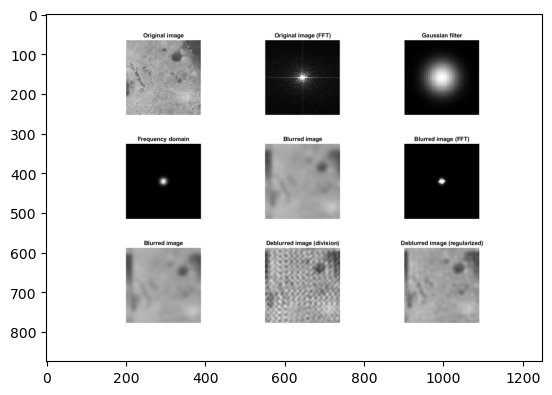

In [6]:
import matplotlib.pyplot as plt
im = plt.imread('1.png')
plt.imshow(im)

In the following Python example, we will do frequency filtering using an exponential filter. This procedure is closely related to the upward(or downward) continuation in the analysis of potential fields.

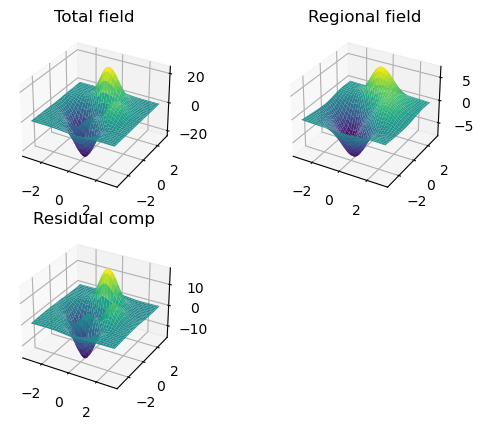

In [20]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

a = 10
N = 64
h, x, y = peaks(N) #"Peaks" function
H = fftshift(fft2(h))
[K, KX, KY] = knum2([N, N], [100, 100])

# Frequency filtering  
hf = ifft2(ifftshift(H * np.exp(-a * K)))
# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x,y,h,cmap = plt.cm.viridis)
ax1.set_title('Total field')
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x,y,hf,cmap = plt.cm.viridis)
ax2.set_title('Regional field')
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x,y,h - hf,cmap = plt.cm.viridis)
ax3.set_title('Residual comp')
plt.show()

#2D Wavenumbers
def knum2(mn,pl):
    # Matrix size
    M, N = mn

    # Physical dimension
    ly, lx = pl

    # Sampling interval
    dx = lx / (N - 1)
    dy = ly / (M - 1)

    # Wave vector axes
    kx = 2 * np.pi * np.linspace(-np.floor(N/2),np.floor((N-1)/2),N) / N / dx
    ky = 2 * np.pi * np.linspace(-np.floor(M/2),np.floor((M-1)/2),M) / M / dy

    # Wavenumbers
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX ** 2 + KY ** 2)

    return K, KX, KY

# example test surface (MATLAB peaks function)
def peaks(N):
    x, y = np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N))
    z = 3 * (1 - x) ** 2 * np.exp(-(x ** 2) - (y + 1) ** 2) \
    - 10 * (x/5 - x ** 3 - y ** 5) * np.exp(-x ** 2 - y ** 2) \
    - 2/3 * np.exp(-(x + 1) ** 2 - y ** 2)
    return z, x, y